# 1. Inverse filter design and implementation

The first step in the signal processing for the device is to **implement a filter that allow us to correct the microphone's characteristic response**. Since we assume that we are dealing with an **LTI system** (linear and time-invariant system), the idea is to obtain the frequency response of the microphone in order to then design a **filter based on the inverse system**.

**By applying this inverse response, we would then linearize the system response**. So first thing first, we need the system response, for that we've made a measurement in a room with a short reverberation time ($T_{20}$ < 0.2 s), where we compared and average the **response of our system** (henceforth the **device under test or DUT**) with that of a system that is consider to be **linear in the frequency interval of interest**. This is comprised of an **Earthworks M50 ominidirectional measurement microphone** and a **RME Fireface audio interface**. 

A measurement was carried to obtain the **impulse response** of each system by means of the [http://pcfarina.eng.unipr.it/Public/Papers/226-AES122.pdf](**exponential sine sweep**), that allow us to **improve the signal-to-noise ratio**. Several responses were obtained and averaged to finally calculate the **transfer function between both systems**. With this we are able to get rid of the undesired effects of the room, the background noise, and the sound source (among others), since we assume that an approximate equal signal incides on both transducers. Hence, we'd finally get the **desired system's frequency response**.

The basic block diagram of the measurement is as follows:

![img](../img/freq_resp.jpg)

## Impulse response measurement

In the folder `my_thesis/aud/ir/` two of the measured impulse responses for each system are available.

Next, we will load some useful libraries and then do a time plot of one impulse response foe each system.

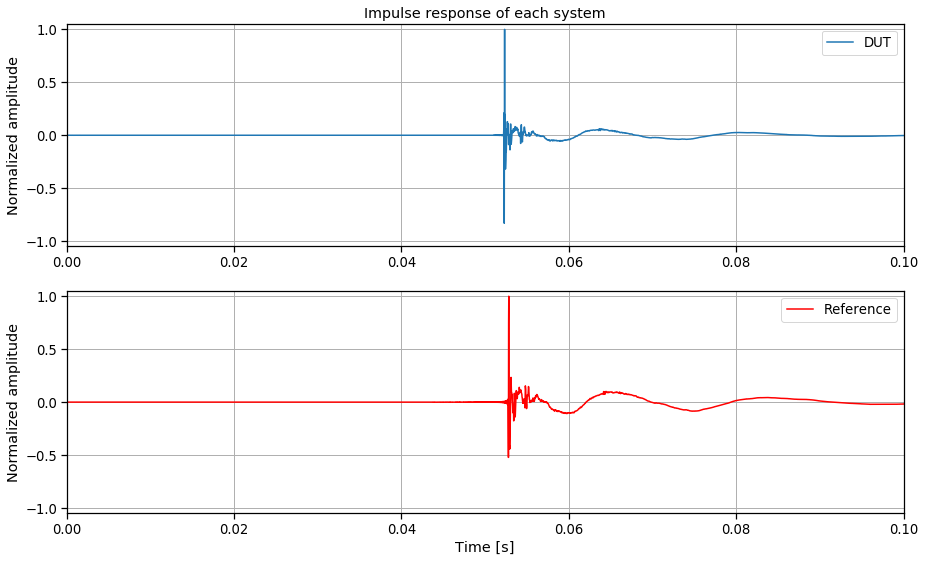

In [489]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import seaborn as sns

#plt.rcParams["figure.figsize"] = (15,9)
sns.set_context('notebook', font_scale=1.2, 
                rc={"figure.figsize": (15,9)})

# load audios
fs, dut_1 = wavfile.read('../aud/ir/dut1.wav')
_, dut_2 = wavfile.read('../aud/ir/dut2.wav')
_, ref_1 = wavfile.read('../aud/ir/ref1.wav')
_, ref_2 = wavfile.read('../aud/ir/ref2.wav')

# prepare figure
fig, ax = plt.subplots(2, 1)

# plot
ax[0].plot(np.arange(len(dut_1))/fs, dut_1/max(dut_1), label='DUT')
ax[1].plot(np.arange(len(ref_1))/fs, ref_1/max(ref_1), 'r', label='Reference')

# plot config
for ax_ in ax:
    ax_.set_xlim([0, 0.10])
    ax_.set_ylim([-1.05, 1.05])
    ax_.legend(loc='upper right')
    ax_.set_ylabel('Normalized amplitude');
    ax_.grid('on')
    
ax[0].set_title('Impulse response of each system')
ax[1].set_xlabel('Time [s]');

## Frequency response

To calculate the desired **transfer function** we first need to get each system's frequency response. This will be done by computing and averaging each measurement's spectrum by means of the **FFT**.

We will define some useful functions that will help us to get the average FFT for each system.

In [10]:
def spec(x, nfft=2**16, window='rect'):
    """ Compute the FFT spectrum of the input audio signal 'x'. 
    The number of points for which to compute the FFT can be 
    specified by 'nfft'. Its possible to select a Hanning or Flattop
    window, in which case corrections are applied to obtain accurate 
    measurements based on the spectrum. """
    freq = fs/2*np.linspace(0, 1, int(nfft/2)+1)  # FFT frequency vector
    if window == 'hann':
        window = np.hanning(len(x))  # Hann window
        CPG = 6.02 # Coherent Power Gain [dB]
        data = x*window
    elif window == 'flat':
        window = flattop(len(x))  # flattop window
        CPG = 13.3 # Coherent Power Gain [dB]
        data = x*window
    else:
        data = x
    sp = np.fft.rfft(data, nfft)
    spp = np.abs(sp)/nfft
    return spp, freq

def ref_f(x, f):
    """ References the input signal 'x' at 1 kHz according
    to the frequency array 'f'. """
    idx = (np.abs(f-1000)).argmin()
    return x-x[idx]

def fft_average(x, nfft=2**16):
    """ Receives a tuple or list of audio arrays 'x', calculates and 
    normalizes the FFT spectrum of each of them and returns their average. 
    With 'nfft' the number of FFT points can be modified. """
    X = np.empty([len(x), int(nfft/2+1)])
    xn = np.empty([len(x), int(nfft/2+1)])
    y = np.empty(int(nfft/2))
    for i in range(len(x)):
        X[i,:], freq = spec(x[i], nfft=nfft)
        xn[i,:] = 1 + ref_f(X[i,:], freq)
    y = np.apply_along_axis(np.mean, 0, xn)
    return y, freq

Having specified the functions needed to compute and average the spectrum of both systems we're ready to calculate the transfer function between them.

Next, we'll compute the `fft_average` (referenced at 1 kHz) for each system and show a comparative plot of them.

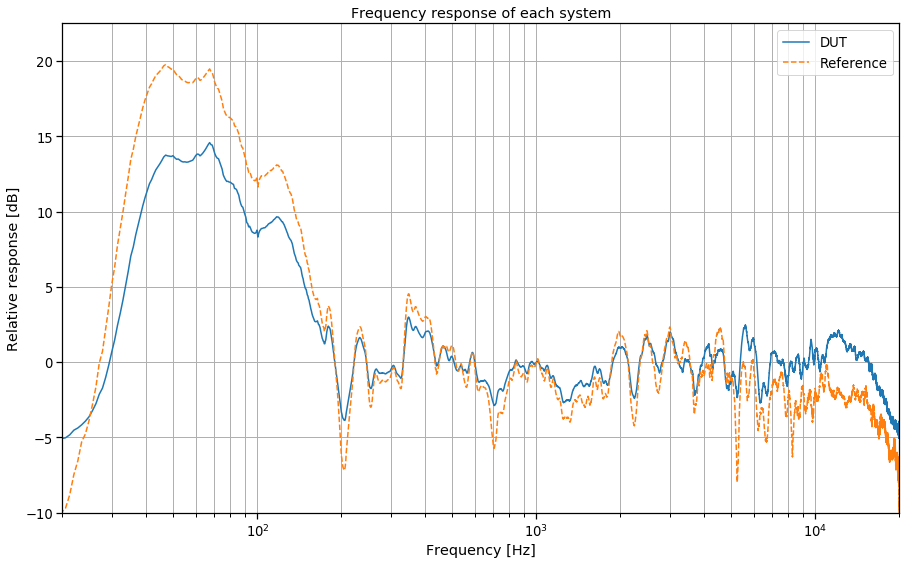

In [490]:
# getting each system's average response
dut_avg, freq = fft_average([dut_1, dut_2])
ref_avg, _ = fft_average([ref_1, ref_2])

# plotting the absolute value of the FFT
plt.semilogx(freq, 20*np.log10(dut_avg), label='DUT')
plt.semilogx(freq, 20*np.log10(ref_avg), '--', label='Reference')

plt.xlim([20, 20000])
plt.ylim([-10, 22.5])
plt.title('Frequency response of each system')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Relative response [dB]')
plt.legend()
plt.grid(which='both', axis='both');

Generally speaking we can see that the responses are similar in the range from 200 Hz to 5 kHz. In the low-end of the spectrum we see an underestimation of in the DUT's response as compared to the reference, whereas the opposite happens in the high-ned of the spectrum.

As said, **by comparing both responses we can show the DUT frequency response**.

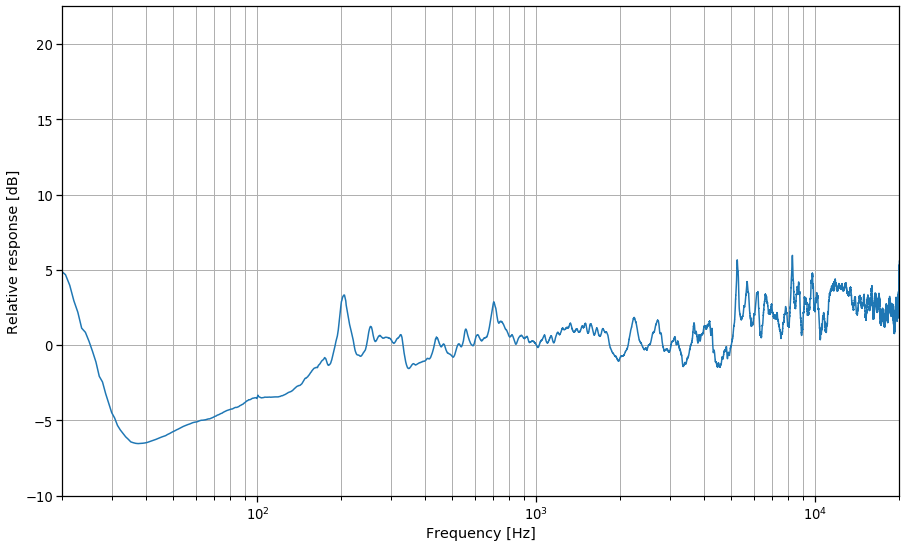

In [481]:
plt.semilogx(freq, 20*np.log10(dut_avg/ref_avg))

plt.xlim([20, 20000])
plt.ylim([-10, 22.5])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Relative response [dB]')

plt.grid(which='both', axis='both');

In [406]:
inv = ref_f(10*np.log10(ref_avg/dut_avg), freq)

inv_reg = F_inv.copy()
inv_reg[np.where(freq < 10)[0]] = 0

In [407]:
def smooth_spectrum(X, freq, Noct=3):
    """ Apply a 1/Noct smoothing to the input frequency spectrum 'X'
    at the 'freq' frequencies.
    Calculates the i-th smoothed spectral coefficient 'X_oct(i)' as 
    the sum of the windowed spectrum. The window is a Gaussian whose
    center frequency is 'freq(i)', and whose sigma is proportional
    to 'freq(i)/Noct'. """
    # initial spectrum
    X_oct = X.copy()
    if Noct > 0:
        for i in np.arange(np.where(freq>0)[0][0], len(freq)):
            g = gauss_f(freq=freq, f0=freq[i], Noct=Noct)
            X_oct[i] = sum(g*X)
    # avoid undershoot
    if min(X) >= 0:
        X_oct[X_oct<0] = 0
    return X_oct

def gauss_f(freq, f0, Noct):
    """ Calculate frequency-domain Gaussian with unity gain. 
    Inputs:
    freq: array of frequencies in which to do the computation.
    f_0: center frequency.
    Noct: determines the bandwith as f_0/Noct. """
    # standard deviation
    sigma = (f0/Noct)/np.pi
    # Gaussian
    g = np.exp(-(((freq-f0)**2)/(2*(sigma**2))))
    # magnitude normalizaition
    return g/sum(g)

In [408]:
F_inv = smooth_spectrum(inv_reg, freq, Noct=3)

(20, 20000)

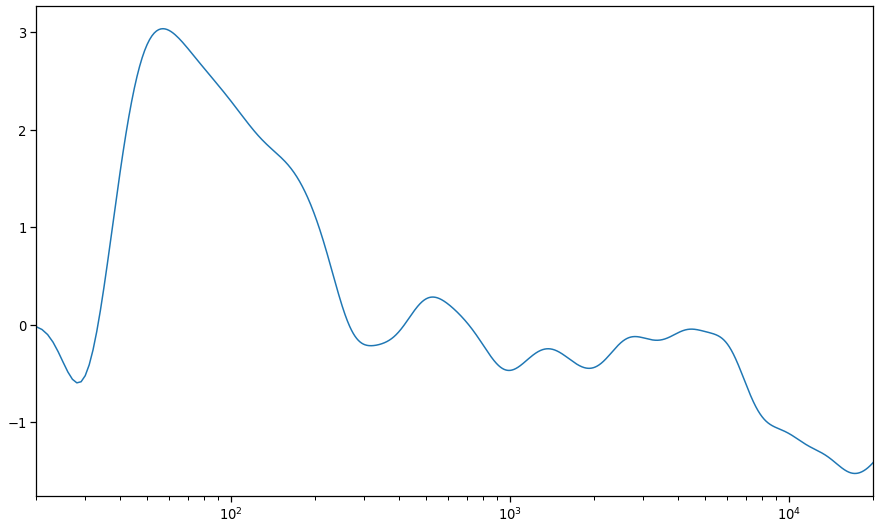

In [409]:
plt.semilogx(F_inv)

plt.xlim([20, 20000])

plt.semilogx(F_inv)

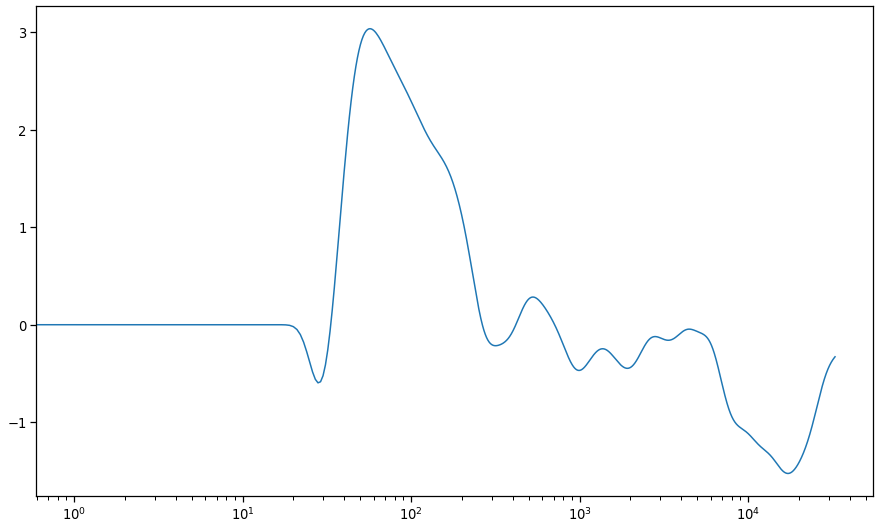

In [410]:
plt.semilogx(F_inv)

In [443]:
from scipy.signal import freqz, firls

dict_finv = {}

rta_inversa = 1 + ref_f(10*(F_inv/20), freq)

for i, taps in enumerate(2**np.arange(9, 15) - 1):
    
    filt = firls(taps, freq[1:], rta_inversa[1:], fs=fs)
    dict_finv[f'filt_{i}'] = filt
    dict_finv[f'taps_{i}'] = taps

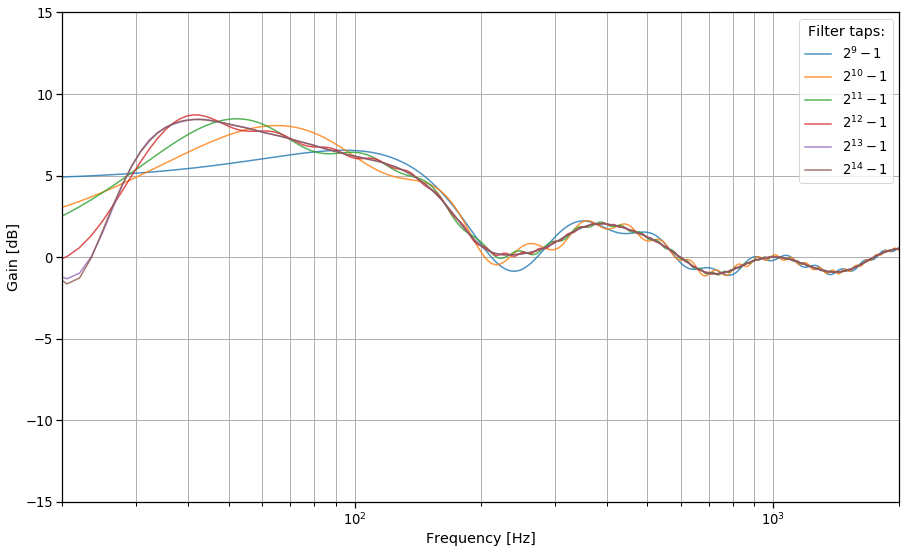

In [454]:
for j in np.arange(6):
    
    # get filter response
    wr, hr = freqz(dict_finv[f'filt_{j}'], worN=2**14)
    # plot
    plt.plot((fs*0.5/np.pi)*wr, 20*np.log10(abs(hr)), 
             label='$2^{' + str(int(np.log2(dict_finv[f'taps_{j}']+1))) + '}-1$', 
             alpha=0.8)
                             
plt.xscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.ylim([-15, 15])
plt.xlim([20, 2000])
plt.grid(which='both', axis='both')
plt.legend(title='Filter taps:');

In [453]:
# saving filter
#np.save('H.npy', dict_finv['filt_4'])

In [ ]:
# loading filter
H = np.load('H.npy')